In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
df = pd.read_csv("Shut in lifts incidents attended by LFB in last 36 months (1).csv", encoding= 'unicode_escape')

# dropping all columns except DateTimeOfCall
df = df[['DateTimeOfCall']]

# extracting date from DateTimeOfCall
import re

incident_date = []
date_pattern = r'(\d{2}/\d{2}/\d{4}) (\d{2}):(\d{2})'

for t in df['DateTimeOfCall']:
    match = re.match(date_pattern, t)
    if(match):
        incident_date.append(match.group(1))
        
df['date'] = incident_date
df.drop('DateTimeOfCall', axis = 1, inplace = True)
df.head()

,date
0,01/10/2018
1,01/10/2018
2,01/10/2018
3,01/10/2018
4,01/10/2018


In [94]:
X_idx = 0; y_idx = 1

data_dict = {}

for date in df['date']:
      
      key = date
      data_dict[key] = [date, 0]

for idx in range(len(df['date'])):
    
    key = df.loc[idx, 'date']

    if key in data_dict.keys():
        data_dict[key][y_idx] += 1
    else:
        print("Error: The key " + key + " does not exist in the dictionary. Count aborted!")
        break

In [95]:
del df
df = pd.DataFrame()
df['ds'] = np.array([data_dict[idx][X_idx] for idx in data_dict.keys()])
df['y'] = np.array([data_dict[idx][y_idx] for idx in data_dict.keys()])

df['ds'] = pd.to_datetime(df['ds'], format = '%d/%m/%Y')
df.head()

,ds,y
0,2018-10-01,16
1,2018-10-02,17
2,2018-10-03,13
3,2018-10-04,11
4,2018-10-05,15


In [96]:
# df.to_csv('london_all_count_dataset.csv', encoding='utf-8')
# ! cp ./london_all_count_dataset.csv '/content/drive/MyDrive/Colab Notebooks'

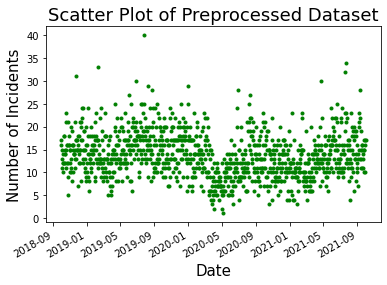

In [97]:
# create scatter plot of preprocessed dataset
fig, ax = plt.subplots()
ax.plot_date(df['ds'], df['y'], color='g', marker='.')
fig.autofmt_xdate()
plt.title('Scatter Plot of Preprocessed Dataset', size = 18)
plt.xlabel ( 'Date', size = 15 )
plt.ylabel ( 'Number of Incidents', size = 15 )
plt.show()

In [98]:
df_train = df.iloc[:1004,:]
df_test = df.iloc[1004:,:]

In [99]:
from prophet import Prophet

m = Prophet(interval_width = 0.95, daily_seasonality = True)
model = m.fit(df_train)

In [100]:
future = m.make_future_dataframe ( periods = 92, freq = 'D' )
forecast = m.predict ( future ) 
forecast['yhat_lower'] = forecast['yhat_lower'].round(decimals=0)
forecast.yhat_lower = forecast.yhat_lower.astype(int)
forecast['yhat'] = forecast['yhat'].round(decimals=0)
forecast.yhat = forecast.yhat.astype(int)
forecast['yhat_upper'] = forecast['yhat_upper'].round(decimals=0)
forecast.yhat_upper = forecast.yhat_upper.astype(int)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-01,15.817645,7,24,15.817645,15.817645,-0.413806,-0.413806,-0.413806,-0.699068,-0.699068,-0.699068,-1.035803,-1.035803,-1.035803,1.321065,1.321065,1.321065,0.0,0.0,0.0,15
1,2018-10-02,15.819072,7,24,15.819072,15.819072,-0.423526,-0.423526,-0.423526,-0.699068,-0.699068,-0.699068,-0.923944,-0.923944,-0.923944,1.199486,1.199486,1.199486,0.0,0.0,0.0,15
2,2018-10-03,15.820498,7,24,15.820498,15.820498,-0.321623,-0.321623,-0.321623,-0.699068,-0.699068,-0.699068,-0.694167,-0.694167,-0.694167,1.071612,1.071612,1.071612,0.0,0.0,0.0,15
3,2018-10-04,15.821924,7,23,15.821924,15.821924,-0.800457,-0.800457,-0.800457,-0.699068,-0.699068,-0.699068,-1.041367,-1.041367,-1.041367,0.939978,0.939978,0.939978,0.0,0.0,0.0,15
4,2018-10-05,15.823351,9,25,15.823351,15.823351,1.129687,1.129687,1.129687,-0.699068,-0.699068,-0.699068,1.021652,1.021652,1.021652,0.807103,0.807103,0.807103,0.0,0.0,0.0,17


In [101]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1091,2021-09-26,16.614885,9,25,16.234265,16.990348,0.728189,0.728189,0.728189,-0.699068,-0.699068,-0.699068,-0.312994,-0.312994,-0.312994,1.740251,1.740251,1.740251,0.0,0.0,0.0,17
1092,2021-09-27,16.627872,9,25,16.241899,17.009165,-0.054900,-0.054900,-0.054900,-0.699068,-0.699068,-0.699068,-1.035803,-1.035803,-1.035803,1.679971,1.679971,1.679971,0.0,0.0,0.0,17
1093,2021-09-28,16.640858,8,25,16.247377,17.029109,-0.019962,-0.019962,-0.019962,-0.699068,-0.699068,-0.699068,-0.923944,-0.923944,-0.923944,1.603051,1.603051,1.603051,0.0,0.0,0.0,17
1094,2021-09-29,16.653845,9,25,16.252854,17.046848,0.118018,0.118018,0.118018,-0.699068,-0.699068,-0.699068,-0.694167,-0.694167,-0.694167,1.511253,1.511253,1.511253,0.0,0.0,0.0,17
1095,2021-09-30,16.666831,8,24,16.258331,17.065942,-0.333818,-0.333818,-0.333818,-0.699068,-0.699068,-0.699068,-1.041367,-1.041367,-1.041367,1.406617,1.406617,1.406617,0.0,0.0,0.0,16


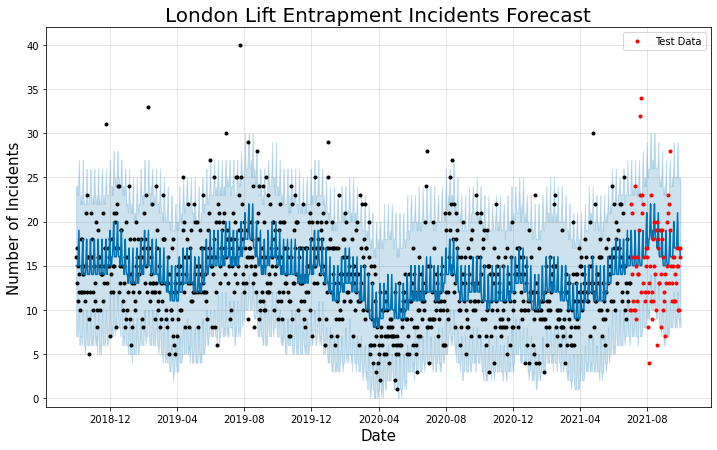

In [102]:
plot_1_London = m.plot(forecast)
ax = plot_1_London.gca()
ax.plot_date(df_test['ds'], df_test['y'], color='r', marker='.', label = 'Test Data')
ax.set_title("London Lift Entrapment Incidents Forecast", size=20)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Number of Incidents", size=15)
ax.set_ylim(-1, 42)
ax.legend()

In [103]:
forecast_train = forecast.iloc[:1004,:]
forecast_test = forecast.iloc[1004:,:]

In [114]:
# print various forecast accuracy scores
def forecast_scores ( y, yhat, yhat_lower, yhat_upper ):
    
    mape = np.mean ( np.abs(yhat - y) / np.abs(y) ).round(3)
    print ( f'\tMean Absolute Percentage Error (MAPE) = {mape}' )

    me = np.mean ( yhat - y ).round(3)
    print ( f'\tMean Error (ME) = {me}' )

    mae = np.mean ( np.abs(yhat - y) ).round(3)
    print ( f'\tMean Absolute Error (MAE) = {mae}' )

    mpe = np.mean ( (yhat - y) / y ).round(3)
    print ( f'\tMean Percentage Error (MPE) = {mpe}' )

    rmse = ( np.mean( (yhat - y)**2 )**.5 ).round(3)
    print ( f'\tRoot Mean Squared Error (RMSE) = {rmse}' )

    corr = ( np.corrcoef ( yhat, y )[0,1] ).round(3)
    print ( f'\tCorrelation = {corr}' )

    mins = np.amin ( np.hstack ( [yhat[:,None], y[:,None]] ), axis=1 )
    maxs = np.amax ( np.hstack ( [yhat[:,None], y[:,None]] ), axis=1 )
    minmax = ( 1 - np.mean ( mins / maxs ) ).round(3)
    print ( f'\tMin-Max Error = {minmax}' )

    out_count = 0

    for idx in range(len(y)):
      if ( y[idx] < yhat_lower[idx] or y[idx] > yhat_upper[idx]):
        out_count += 1
        
    p_out = round ( ( out_count / len(y) * 100 ), 3 )
    print ( f'\tPercentage of Outliers = {p_out}')

    correct_predictions = 0

    for idx in range(len(y)):
      if ( y[idx] == yhat[idx] ):
        correct_predictions += 1
    
    p_perf = round ( ( correct_predictions / len(y) * 100 ), 3 )
    print ( f'\tPercentage of perfect predictions = {p_perf}')


# storing y's and yhat's into numpy arrays
y_train = df_train.loc[:,'y']; y_train = y_train.values
yhat_train = forecast_train.loc[:,'yhat']; yhat_train = yhat_train.values
y_test = df_test.loc[:,'y']; y_test = y_test.values
yhat_test = forecast_test.loc[:,'yhat']; yhat_test = yhat_test.values
yhat_lower_train = forecast_train.loc[:,'yhat_lower']; yhat_lower_train = yhat_lower_train.values
yhat_lower_test = forecast_test.loc[:,'yhat_lower']; yhat_lower_test = yhat_lower_test.values
yhat_upper_train = forecast_train.loc[:,'yhat_upper']; yhat_upper_train = yhat_upper_train.values
yhat_upper_test = forecast_test.loc[:,'yhat_upper']; yhat_upper_test = yhat_upper_test.values

print ( 'Forecast scores on trainting data:' )
forecast_scores ( y_train, yhat_train, yhat_lower_train, yhat_upper_train )
print ( '\nForecast scores on test data:' )
forecast_scores ( y_test, yhat_test, yhat_lower_test, yhat_upper_test )

Forecast scores on trainting data:
	Mean Absolute Percentage Error (MAPE) = 0.307
	Mean Error (ME) = -0.008
	Mean Absolute Error (MAE) = 3.273
	Mean Percentage Error (MPE) = 0.133
	Root Mean Squared Error (RMSE) = 4.182
	Correlation = 0.533
	Min-Max Error = 0.211
	Percentage of Outliers = 3.685
	Percentage of perfect predictions = 9.462

Forecast scores on test data:
	Mean Absolute Percentage Error (MAPE) = 0.371
	Mean Error (ME) = 1.793
	Mean Absolute Error (MAE) = 4.511
	Mean Percentage Error (MPE) = 0.258
	Root Mean Squared Error (RMSE) = 5.671
	Correlation = 0.065
	Min-Max Error = 0.239
	Percentage of Outliers = 7.609
	Percentage of perfect predictions = 7.609


In [122]:
def baseline_model(data, idx):
  return data[idx] if idx == 0 else data[idx - 1]

bfc_train = []; bfc_test = []

# baseline prediction on training data
for idx in range(len(y_train)):
  bfc_train.append(baseline_model(y_train, idx))
bfc_train = np.array(bfc_train)
print ( 'Baseline Model\'s forecast scores on trainting data:' )
forecast_scores ( y_train, bfc_train, bfc_train, bfc_train )

# baseline prediction on test data
for idx in range(len(y_test)):
  bfc_test.append(baseline_model(y_test, idx))
bfc_test = np.array(bfc_test)
print ( '\nBaseline Model\'s forecast scores on test data:' )
forecast_scores ( y_test, bfc_test, bfc_test, bfc_test )

Baseline Model's forecast scores on trainting data:
	Mean Absolute Percentage Error (MAPE) = 0.4
	Mean Error (ME) = 0.003
	Mean Absolute Error (MAE) = 4.567
	Mean Percentage Error (MPE) = 0.121
	Root Mean Squared Error (RMSE) = 5.79
	Correlation = 0.313
	Min-Max Error = 0.278
	Percentage of Outliers = 93.625
	Percentage of perfect predictions = 6.375

Baseline Model's forecast scores on test data:
	Mean Absolute Percentage Error (MAPE) = 0.369
	Mean Error (ME) = -0.076
	Mean Absolute Error (MAE) = 5.12
	Mean Percentage Error (MPE) = 0.097
	Root Mean Squared Error (RMSE) = 6.619
	Correlation = 0.192
	Min-Max Error = 0.269
	Percentage of Outliers = 93.478
	Percentage of perfect predictions = 6.522
